In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from numpy import loadtxt
#from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
#from sklearn.cross_validation import cross_val_predict, KFold
#from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import utils_ml

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
%matplotlib inline

# Loading data

In [2]:
#df = pd.read_csv("data/cleaned_new_loans_with_dummy_outlier_removed.csv")
#df = pd.read_csv("data/cleaned_new_loans_with_dummy_outlier_removed_dispurseddate_new.csv")
df = pd.read_csv("data/cleaned_newdata.csv")
df_bin = pd.read_csv("data/cleaned_newdata_binned.csv")

#df=utils_ml.create_ratio_parameters_consumer(df) #


In [28]:
df=df[columns_top40]
df_bin=df_bin[columns_top40_bin]

df,df_bin=utils_ml.convert_features_to_binned(df,df_bin)

In [30]:
df.columns=df.columns.str.replace(' ','_')
df_bin.columns=df_bin.columns.str.replace(' ','_')
df.columns=df.columns.str.replace('(','')
df.columns=df.columns.str.replace(')','')
df_bin.columns=df_bin.columns.str.replace('(','')
df_bin.columns=df_bin.columns.str.replace(')','')

In [31]:
df_train,df_test=utils_ml.split_samples_consumer(df, write_sample=False)
df_train_bin,df_test_bin=utils_ml.split_samples_consumer(df_bin, write_sample=True)

In [32]:
df_train.bad.sum(),df_test.bad.sum()

(2341, 1052)

In [33]:
df_train_bin.bad.sum(),df_test_bin.bad.sum()

(2341, 1052)

In [34]:
df_train_bin.bad.mean(),df_test_bin.bad.mean()

(0.05073358906009579, 0.0531957928802589)

In [13]:
df_columns_groups=utils_ml.groups_importance_list_consumer(importance_list)

In [21]:
df=df[['bad']+importance_list]
df_train=df_train[['bad']+importance_list]
df_test=df_test[['bad']+importance_list]

# Train-Test split

In [23]:
sScaler = StandardScaler(copy=True, with_mean=True, with_std=True)
mScaler = MinMaxScaler()

In [33]:
X = df.drop('bad', axis=1)
y = df.bad

X_train, X_test , y_train, y_train = train_test_split(X, y, test_size=0.7)

In [34]:
sScaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [35]:
X_train = sScaler.transform(X_train)
X_test = sScaler.transform(X_test)
#X = sScaler.transform(X)

# Fitting

In [36]:
def cvDictGen(functions, scr, X_train=X_train, y_train=y_train, cv=5, verbose=1):
    cvDict = {}
    for func in functions:
        cvScore = cross_val_score(func, X_train, y_train, cv=cv, verbose=verbose, scoring=scr)
        cvDict[str(func).split('(')[0]] = [cvScore.mean(), cvScore.std()]
    
    return cvDict

def cvDictNormalize(cvDict):
    cvDictNormalized = {}
    for key in cvDict.keys():
        for i in cvDict[key]:
            cvDictNormalized[key] = ['{:0.2f}'.format((cvDict[key][0]/cvDict[cvDict.keys()[0]][0])),
                                     '{:0.2f}'.format((cvDict[key][1]/cvDict[cvDict.keys()[0]][1]))]
    return cvDictNormalized

In [37]:
glmMod = LogisticRegression(penalty='l2', C=1, fit_intercept=True, verbose=2)
adaMod = AdaBoostClassifier(n_estimators=55, learning_rate=1.0)


gbMod = GradientBoostingClassifier(learning_rate=0.005, \
        n_estimators=1000,min_samples_split=600,max_features=5, \
        max_depth = 5, min_samples_leaf = 400,
        subsample=0.8, random_state=10, warm_start=True)

rfMod = RandomForestClassifier(n_estimators=1000, oob_score = True,max_features=5, \
                               min_samples_split=600,\
                                min_samples_leaf=300, max_depth=8,random_state=10)


xgbMod = XGBClassifier()

In [38]:
cvD = cvDictGen(functions=[glmMod, adaMod, gbMod, rfMod, xgbMod],\
                         X_train=X_train, y_train=y_train, scr='roc_auc')

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.5s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.6min finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.4min finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.6s finished


In [39]:
cvD

{'AdaBoostClassifier': [0.7358197841230869, 0.0027681721716876985],
 'GradientBoostingClassifier': [0.7445378718222126, 0.005849020285634077],
 'LogisticRegression': [0.7243581520941813, 0.004047123147593248],
 'RandomForestClassifier': [0.7351701808344021, 0.003930123393026762],
 'XGBClassifier': [0.7413371922606803, 0.004562082054616567]}

In [40]:
xgbMod.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [41]:
gbMod.fit(X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.005, loss='deviance', max_depth=5,
              max_features=5, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=400, min_samples_split=600,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=True)

In [42]:
rfMod.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=300, min_samples_split=600,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=True, random_state=10, verbose=0, warm_start=False)

In [43]:
glmMod.fit(X_train,y_train)

[LibLinear]

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=2, warm_start=False)

In [44]:
adaMod.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=55, random_state=None)

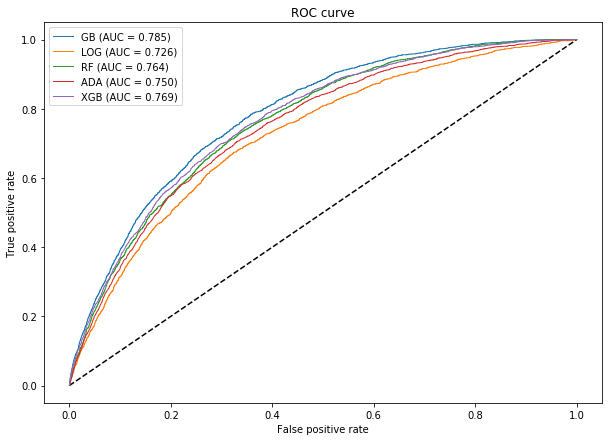

In [45]:
roc_train=utils_ml.plot_RocCurve_models(X_train, y_train, [gbMod,glmMod,rfMod,adaMod,xgbMod],\
                ['GB','LOG','RF','ADA','XGB'] )

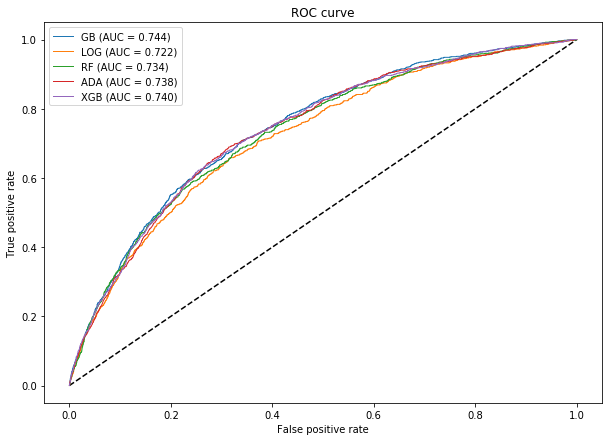

In [46]:
roc_test=utils_ml.plot_RocCurve_models(X_test, y_test,\
                [gbMod,glmMod,rfMod,adaMod,xgbMod],\
                ['GB','LOG','RF','ADA','XGB'] )

In [47]:
df_cv_train=pd.DataFrame(cvD.items(),columns=['model','cv_train'])
df_cv_train.model=['XGB','LOG','ADA','GB','RF']

df_roc=pd.DataFrame(roc_test.items(),columns=['model','test'])
df_roc=pd.merge(df_roc,pd.DataFrame(roc_train.items(),columns=['model','train']))
df_roc=pd.merge(df_roc,df_cv_train)

df_roc

,model,test,train,cv_train
0,RF,0.734258,0.763966,"[0.7351701808344021, 0.003930123393026762]"
1,ADA,0.737799,0.749684,"[0.7358197841230869, 0.0027681721716876985]"
2,XGB,0.740281,0.768854,"[0.7413371922606803, 0.004562082054616567]"
3,GB,0.744175,0.784994,"[0.7445378718222126, 0.005849020285634077]"
4,LOG,0.722392,0.725663,"[0.7243581520941813, 0.004047123147593248]"


# Recursive Feature Elimination

Feature ranking:
1. feature occupation_duration_total (0.303472)
2. feature branch_region (0.211085)
3. feature total_income (0.135370)
4. feature CollateralValueToDebt_Ratio (0.123446)
5. feature gender (0.087538)
6. feature exposure_3 (0.047220)
7. feature days_with_bank (0.038002)
8. feature exposure_1 (0.024385)
9. feature dependent (0.023308)
10. feature exposure_2 (0.006173)


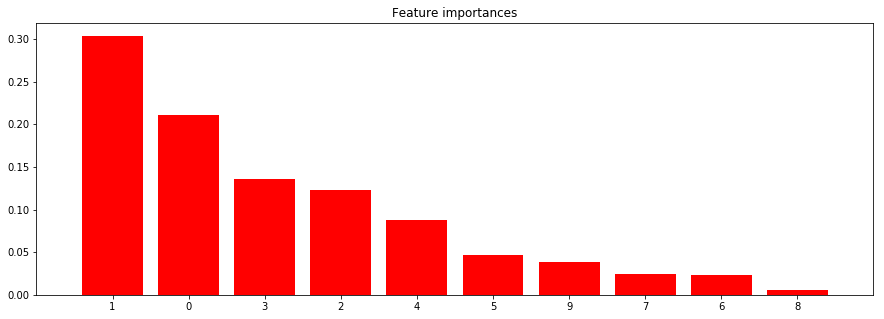

In [49]:
rfMod.fit(X_train,y_train)

forest = rfMod

importances = forest.feature_importances_
#std = np.std([tree.feature_importances_ for tree in forest.n_estimators], axis=0)

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, X.columns[indices[f]], 
                                   importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(15,5))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", align="center")
#color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

# Building Scorecard

In [39]:
df_train_bin2=df_train_bin[['bad']+importance_list_bin]
df_test_bin2=df_test_bin[['bad']+importance_list_bin]
df_bin2=df_bin[['bad']+importance_list_bin]

In [83]:
columns_group=df_bin2.columns.tolist()

df_group=utils_ml.groups_importance_list_consumer(importance_list_bin)
df_group.columns=[u'feature', u'ranking', u'group']
#df_group.feature=columns_group[1:]
#df_group.loc[df_group[df_group.feature=='residence_ownership'].index,'group']='demographic'
#df_group.loc[df_group[df_group.feature=='sector_type'].index,'group']='business'
df_group.loc[df_group[df_group.feature=='exposure'].index,'group']='employment'
df_group

,feature,ranking,group
0,occupation_duration_total,0.868,employment
1,branch_region,0.848,demographic
2,days_with_bank,0.800,demographic
3,CollateralValueToDebt_Ratio,1.000,finance
4,TotalincomeToDebt_Ratio,NaN,finance
5,total_income,0.700,finance
6,exposure,NaN,employment
7,gender,0.844,demographic
8,dependent,0.322,demographic


In [84]:
%%time
df_train_result=run_100fits_consumer(df_train_bin2)

CPU times: user 16min 3s, sys: 17.4 s, total: 16min 21s
Wall time: 3min 5s


Test  : Train
0.728 0.731


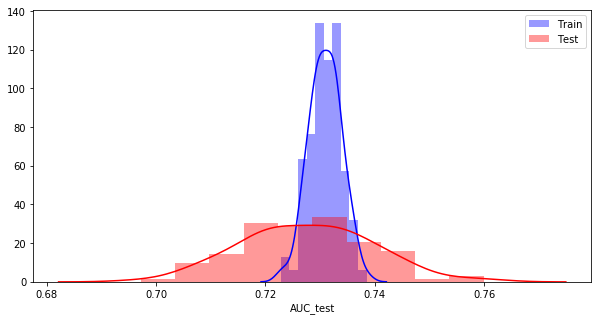

In [85]:
show_results_100fits(df_train_result)

In [74]:
corr_par_list(df_train_result,corr_limit=0.30)

,level_0,level_1,corr_coeff
30,total_income,branch_region,0.378118
51,branch_region,total_income,0.378118


In [75]:
df_tmp=unstable_features(df_train_result)
df_tmp['weight']=np.round(df_tmp['mean']/df_tmp['mean'].sum(),2)
df_tmp=df_tmp.sort_values(by='mean',ascending=False)
#df_tmp
df_tmp=pd.merge(df_tmp,df_group)
df_tmp

,feature,mean,std,std_percent,weight,ranking,group
0,total_income,1.089435,0.052369,0.05,0.20,0.700,finance
1,gender,1.083767,0.050720,0.05,0.20,0.844,demographic
2,branch_region,0.825645,0.025936,0.03,0.15,0.848,demographic
3,occupation_duration_total,0.637313,0.022840,0.04,0.12,0.868,employment
4,exposure,0.576548,0.031512,0.05,0.10,NaN,employment
5,CollateralValueToDebt_Ratio,0.528539,0.039377,0.07,0.10,1.000,finance
6,dependent,0.496589,0.060655,0.12,0.09,0.322,demographic
7,days_with_bank,0.284933,0.035402,0.12,0.05,0.800,demographic


In [76]:
df_tmp.groupby('group')['weight'].sum().reset_index().sort_values(by='weight',ascending=False)

,group,weight
0,demographic,0.49
2,finance,0.30
1,employment,0.22


In [77]:
df_train_card,df_train_score,df_train_fit=run_1fit_consumer(df_train_bin2)

In [78]:
df_train_card=df_train_card.reset_index().drop('index',1)
df_train_score=df_train_score.reset_index().drop('index',1)
df_train_fit=df_train_fit.reset_index().drop('index',1)
df_train_bin2=df_train_bin2.reset_index().drop('index',1)
df_train_bin=df_train_bin.reset_index().drop('index',1)

In [363]:
df_train_score=pd.concat([df_train_bin[['bad','clientid','accountid']],df_train_score],1)

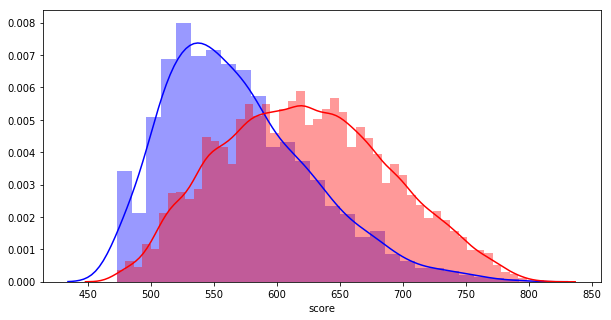

In [364]:
plt.figure(figsize=(10,5))
sns.distplot( df_train_score[df_train_score.bad==1]["score"] , color="blue", label="Good", norm_hist=False)
sns.distplot( df_train_score[df_train_score.bad==0]["score"] , color="red", label="Bad",norm_hist=False)
plt.show()

In [365]:
df_scorecard_train=create_scorecard_weight(df_train_card)
df_scorecard_train

,total_point,weight
variable,,
branch_region,70,0.21
occupation_duration_total,66,0.19
total_income,44,0.13
exposure,41,0.12
gender,36,0.11
CollateralValueToDebt_Ratio,32,0.09
days_with_bank,30,0.09
dependent,20,0.06


In [366]:
df_card,df_score,df_fit=run_1fit_consumer(df_bin2)

In [367]:
df_card=df_card.reset_index().drop('index',1)
df_score=df_score.reset_index().drop('index',1)
df_fit=df_fit.reset_index().drop('index',1)
df_bin2=df_bin2.reset_index().drop('index',1)
df_bin=df_bin.reset_index().drop('index',1)
df_total_score=pd.concat([df_bin[['bad','clientid','accountid']],df_score],1)

In [368]:
df_card.points=df_card.points.astype(int)
df_card['total_iv']=df_card['total_iv'].astype(float)
df_card['bin_iv']=df_card['bin_iv'].astype(float)

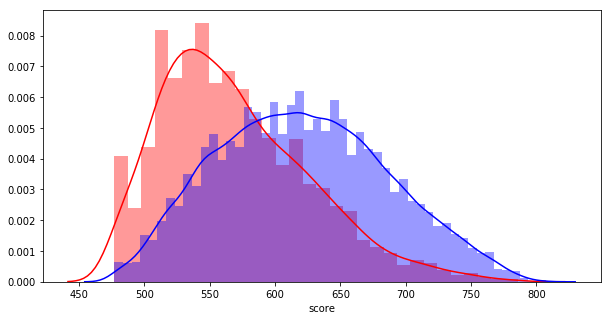

In [369]:
plt.figure(figsize=(10,5))
sns.distplot( df_total_score[df_total_score.bad==1]["score"] , color="red", label="Bad",norm_hist=False)
sns.distplot( df_total_score[df_total_score.bad==0]["score"] , color="blue", label="Good", norm_hist=False)
plt.show()

In [370]:
df_scorecard_rand100=create_scorecard_weight(df_card)
df_scorecard_rand100

,total_point,weight
variable,,
occupation_duration_total,68,0.21
branch_region,67,0.20
total_income,43,0.13
exposure,40,0.12
gender,36,0.11
CollateralValueToDebt_Ratio,29,0.09
days_with_bank,26,0.08
dependent,21,0.06


In [371]:
df_iv=df_card[['variable','total_iv']].drop_duplicates()
df_iv.total_iv=df_iv.total_iv.astype(float)
df_iv=df_iv.sort_values(by='total_iv',ascending=False).round(2)
df_iv

,variable,total_iv
23,occupation_duration_total,0.31
21,branch_region,0.26
7,exposure,0.16
17,days_with_bank,0.12
14,CollateralValueToDebt_Ratio,0.11
5,gender,0.05
10,total_income,0.04
1,dependent,0.04
0,basepoints,0.00


In [375]:
from tqdm import tqdm

seeds=[ 135,  343,  382,  532,  551,  581,  773,  841,  846,  874,  948,
          1036, 1106, 1353, 1542, 1599, 1676, 1768, 1857, 1919, 1996, 2033,
          2218, 2263, 2327, 2347, 2397, 2569, 2592, 2595, 2733, 2748, 2756,
          2785, 2808, 2948, 3008, 3059, 3241, 3258, 3402, 3700, 3744, 3828,
          4008, 4110, 4175, 4506, 4562, 4650, 4658, 4687, 4824, 4978, 5271,
          5295, 5373, 5375, 5501, 5567, 5611, 5737, 5767, 5868, 6203, 6222,
          6289, 6348, 6395, 6416, 6467, 6503, 6517, 6586, 6726, 7115, 7210,
          7221, 7283, 7388, 7429, 7628, 7703, 7716, 7736, 7860, 8279, 8367,
          8459, 8670, 8767, 8915, 8998, 9061, 9151, 9423, 9483, 9636, 9665,
          9764]

df_card_100fits=pd.DataFrame(columns=['seed',u'variable', u'bin', u'count', u'count_distr', u'good', u'bad',
       u'badprob', u'woe', u'bin_iv', u'total_iv', u'points'])

for seed in tqdm(seeds):
    df_card,df_score,df_fit=run_1fit_consumer(df_bin2,seed=seed)
    df_card['seed']=seed
    df_card_100fits=pd.concat([df_card_100fits,df_card])

100%|██████████| 100/100 [11:03<00:00,  6.64s/it]


In [376]:
df_card_100fits.points=df_card_100fits.points.astype(int)
df_tmp=df_card_100fits.groupby(['seed','variable'])['points'].agg(['min','max']).reset_index()
df_tmp['min']=df_tmp['min'].astype(int)
df_tmp['max']=df_tmp['max'].astype(int)
df_tmp['total_point']=df_tmp['max']-df_tmp['min']

df_ave_scorecard=df_tmp.groupby('variable')['total_point'].agg(['mean','std']).reset_index()
df_ave_scorecard['std_percent']=df_ave_scorecard['mean']/df_ave_scorecard['std']
df_ave_scorecard['std_percent']=np.round(df_ave_scorecard['std']/df_ave_scorecard['mean'],2)

df_ave_scorecard.columns=[u'variable', u'ave_score', u'std_value', u'std_percent']
df_ave_scorecard=df_ave_scorecard.sort_values(by='ave_score',ascending=False)
df_ave_scorecard=df_ave_scorecard[df_ave_scorecard.variable!='basepoints']
df_ave_scorecard

,variable,ave_score,std_value,std_percent
2,branch_region,71.91,1.764378,0.02
7,occupation_duration_total,68.46,2.171533,0.03
8,total_income,44.66,2.252810,0.05
6,gender,36.84,1.353783,0.04
5,exposure,36.50,1.909572,0.05
0,CollateralValueToDebt_Ratio,32.45,1.976503,0.06
3,days_with_bank,22.59,2.726951,0.12
4,dependent,21.12,2.075738,0.10


In [377]:
df_scorecard_final=df_scorecard_final.reset_index()
df_scorecard_final

,variable,total_point,weight
0,branch_region,72,0.22
1,occupation_duration_total,68,0.20
2,total_income,45,0.14
3,gender,37,0.11
4,exposure,36,0.11
5,CollateralValueToDebt_Ratio,32,0.10
6,days_with_bank,22,0.07
7,dependent,21,0.06


In [379]:
df_scorecard_train=df_scorecard_train.reset_index()

In [380]:
df_scorecard_rand100=df_scorecard_rand100.reset_index()

In [382]:
df_tmp=pd.merge(df_ave_scorecard,df_scorecard_final,on='variable')
df_tmp['res_in_sigma']=(df_tmp['ave_score']-df_tmp['total_point'])/df_tmp['std_value']
df_tmp=np.round(df_tmp,2)
df_tmp

,variable,ave_score,std_value,std_percent,index,total_point,weight,res_in_sigma
0,branch_region,71.91,1.76,0.02,0,72,0.22,-0.05
1,occupation_duration_total,68.46,2.17,0.03,1,68,0.20,0.21
2,total_income,44.66,2.25,0.05,2,45,0.14,-0.15
3,gender,36.84,1.35,0.04,3,37,0.11,-0.12
4,exposure,36.50,1.91,0.05,4,36,0.11,0.26
5,CollateralValueToDebt_Ratio,32.45,1.98,0.06,5,32,0.10,0.23
6,days_with_bank,22.59,2.73,0.12,6,22,0.07,0.22
7,dependent,21.12,2.08,0.10,7,21,0.06,0.06


In [386]:
df_final_score_acc_cid.head()

,bad,clientid,accountid,dependent_points,gender_points,exposure_points,total_income_points,CollateralValueToDebt_Ratio_points,days_with_bank_points,branch_region_points,occupation_duration_total_points,score
0,0,313690,1010008372,-8.0,-15.0,24.0,-4.0,0.0,1.0,-19.0,24.0,597.0
1,0,7257,1010008414,-8.0,-15.0,-12.0,8.0,0.0,10.0,-19.0,40.0,598.0
2,0,514616,1010008419,-8.0,-15.0,-7.0,24.0,-11.0,-4.0,-19.0,-28.0,526.0
3,0,69054,1010008441,-1.0,-15.0,24.0,8.0,0.0,10.0,-19.0,-1.0,600.0
4,0,516502,1010008467,7.0,22.0,-7.0,-21.0,0.0,-4.0,-19.0,40.0,612.0


In [387]:
variables=df_card_100fits['variable'].unique()[1:]
variables

array(['dependent', 'gender', 'exposure', 'total_income',
       'CollateralValueToDebt_Ratio', 'days_with_bank', 'branch_region',
       'occupation_duration_total'], dtype=object)

dependent
gender
exposure
total_income
CollateralValueToDebt_Ratio
days_with_bank
branch_region
occupation_duration_total


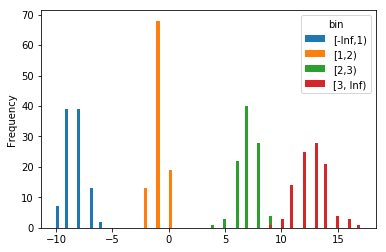

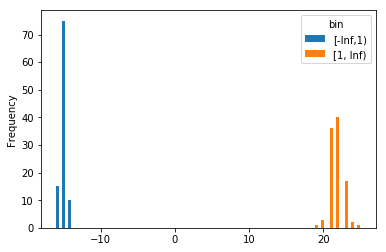

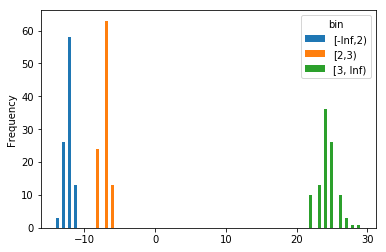

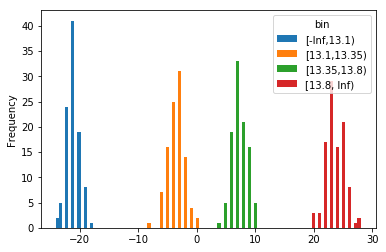

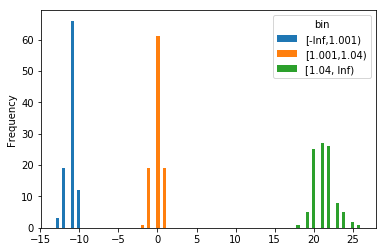

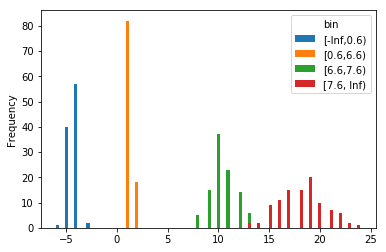

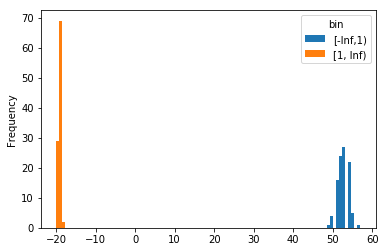

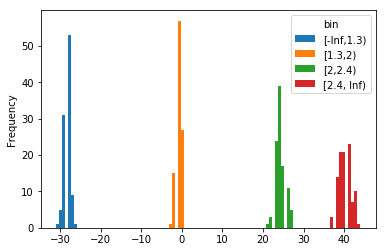

In [388]:
for variable in variables:
    df_tmp3=df_card_100fits[df_card_100fits['variable'] ==variable]\
        [['seed','bin','points']]
    df_tmp3=df_tmp3.pivot(index='seed', columns='bin', values='points')
    df_tmp3=df_tmp3.astype(int)
    print variable
    df_tmp3.plot.hist(bins=100)